This blog post is a rewrite of [post by Jeremy Howard](https://pytorch.org/tutorials/beginner/nn_tutorial.html) - a bottom up approach to learn pytorch basics - highly recommended read.

In [1]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)
        
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

(50000, 784)


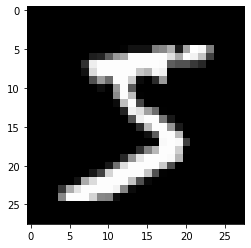

In [4]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

In [5]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


#### nn from scratch (no torch.nn)

In [210]:
import math

weights = torch.randn(784, 10) / math.sqrt(784) # Xavier initialisation

weights.requires_grad_()

bias = torch.zeros(10, requires_grad=True)

##### Learning
logsoftmax is a normalized expotential function

In [213]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

##### Learning
in numpy equivalent of torch.tensor::unsqueeze is np.expand_dims

```np.expand_dims(np.random.randn(15).reshape((5,-1)), -1)```

In [214]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

In [215]:
def accuracy(out, yb):
    return (torch.argmax(out, dim=-1) == yb).float().mean()

training loop:
  - compute batch idexes
  - run batch through model
  - compute loss
  - loss.backward()
  - update gradients

In [216]:
bs = 64
n = x_train.shape[0]
lr = 0.5
epochs = 2

In [217]:
# from IPython.core.debugger import set_trace

weights = torch.randn((784, 10)) / math.sqrt(784)
weights.requires_grad_()

bias = torch.zeros(10, requires_grad=True)

xb, yb = None, None

for epoch in range(epochs):
    for i in range((n-1) // bs + 1):
#         set_trace()
        start_i = bs * i
        end_i = start_i + bs

        xb = x_train[start_i: end_i]
        yb = y_train[start_i: end_i]

        preds = model(xb)
        loss = loss_func(preds, yb)

        loss.backward()

        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()
        if i % 200 == 0:
            print(f"i:{i} epoch:{epoch} acc:{accuracy(preds,yb)} loss:{loss_func(preds, yb)}")

print(f"Final accuracy: {accuracy(model(xb),yb)}, loss: {loss_func(model(xb), yb)}")


i:0 epoch:0 acc:0.125 loss:2.3893065452575684
i:200 epoch:0 acc:0.890625 loss:0.30535614490509033
i:400 epoch:0 acc:0.890625 loss:0.23910431563854218
i:600 epoch:0 acc:0.890625 loss:0.26232966780662537
i:0 epoch:1 acc:0.921875 loss:0.2764670252799988
i:200 epoch:1 acc:0.90625 loss:0.20001156628131866
i:400 epoch:1 acc:0.921875 loss:0.21263916790485382
i:600 epoch:1 acc:0.90625 loss:0.2258358597755432
Final accuracy: 1.0, loss: 0.08194544911384583


### Using nn.functional

In [218]:
import torch.nn.functional as F

In [219]:
loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

In [220]:
accuracy(model(xb), yb)

tensor(1.)

In [221]:
loss_func(model(xb), yb)

tensor(0.0819, grad_fn=<NllLossBackward>)

### Using nn.Module

In [222]:
from torch import nn

In [223]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784,10)/math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))
        
    def forward(self, xb):
        return xb @ self.weights + self.bias

In [224]:
model = Mnist_Logistic()

In [225]:
print(loss_func(model(xb), yb))

tensor(2.3747, grad_fn=<NllLossBackward>)


In [226]:
# from IPython.core.debugger import set_trace
def fit():
    xb, yb = None, None

    for epoch in range(epochs):
        for i in range((n-1) // bs + 1):
    #         set_trace()
            start_i = bs * i
            end_i = start_i + bs

            xb = x_train[start_i: end_i]
            yb = y_train[start_i: end_i]

            preds = model(xb)
            loss = loss_func(preds, yb)

            loss.backward()

            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

            if i % 200 == 0:
                print(f"i:{i} epoch:{epoch} acc:{accuracy(preds,yb)} loss:{loss_func(preds, yb)}")

    print(f"Final accuracy: {accuracy(model(xb),yb)}, loss: {loss_func(model(xb), yb)}")

fit()

i:0 epoch:0 acc:0.046875 loss:2.3504323959350586
i:200 epoch:0 acc:0.890625 loss:0.30370551347732544
i:400 epoch:0 acc:0.890625 loss:0.23531047999858856
i:600 epoch:0 acc:0.890625 loss:0.25988537073135376
i:0 epoch:1 acc:0.921875 loss:0.28092852234840393
i:200 epoch:1 acc:0.90625 loss:0.1964576691389084
i:400 epoch:1 acc:0.9375 loss:0.20972053706645966
i:600 epoch:1 acc:0.90625 loss:0.22323745489120483
Final accuracy: 1.0, loss: 0.08024808019399643


### Using nn.Linear

In [227]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)
        
        
    def forward(self, xb):
        return self.lin(xb)
    
model = Mnist_Logistic()

In [228]:
print(loss_func(model(xb), yb))

tensor(2.3454, grad_fn=<NllLossBackward>)


In [229]:
fit()

i:0 epoch:0 acc:0.171875 loss:2.358887195587158
i:200 epoch:0 acc:0.890625 loss:0.301554799079895
i:400 epoch:0 acc:0.890625 loss:0.23850272595882416
i:600 epoch:0 acc:0.890625 loss:0.26491525769233704
i:0 epoch:1 acc:0.921875 loss:0.28105849027633667
i:200 epoch:1 acc:0.90625 loss:0.19805528223514557
i:400 epoch:1 acc:0.921875 loss:0.2115239053964615
i:600 epoch:1 acc:0.921875 loss:0.2283817082643509
Final accuracy: 1.0, loss: 0.08113232254981995


### Using torch.optim

In [242]:
from torch import optim

In [243]:
def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

In [247]:
def fit2():
    xb, yb = None, None
    model, opt = get_model()

    for epoch in range(epochs):
        for i in range((n-1) // bs + 1):
    #         set_trace()
            start_i = bs * i
            end_i = start_i + bs

            xb = x_train[start_i: end_i]
            yb = y_train[start_i: end_i]

            preds = model(xb)
            loss = loss_func(preds, yb)

            loss.backward()

            opt.step()
            opt.zero_grad()

            if i % 200 == 0:
                print(f"i:{i} epoch:{epoch} acc:{accuracy(preds,yb)} loss:{loss_func(preds, yb)}")

    print(f"Final accuracy: {accuracy(model(xb),yb)}, loss: {loss_func(model(xb), yb)}")

fit2()

i:0 epoch:0 acc:0.1875 loss:2.317516326904297
i:200 epoch:0 acc:0.890625 loss:0.3004288971424103
i:400 epoch:0 acc:0.890625 loss:0.23431403934955597
i:600 epoch:0 acc:0.890625 loss:0.2628122568130493
i:0 epoch:1 acc:0.921875 loss:0.28213852643966675
i:200 epoch:1 acc:0.90625 loss:0.19670134782791138
i:400 epoch:1 acc:0.9375 loss:0.20885488390922546
i:600 epoch:1 acc:0.921875 loss:0.22647500038146973
Final accuracy: 1.0, loss: 0.08074620366096497


### Using Dataset

In [248]:
from torch.utils.data import TensorDataset

In [249]:
train_ds = TensorDataset(x_train, y_train)

In [251]:
def fit3():
    xb, yb = None, None
    model, opt = get_model()
    train_ds = TensorDataset(x_train, y_train)
    
    for epoch in range(epochs):
        for i in range((n-1) // bs + 1):
    #         set_trace()
            start_i = bs * i
            end_i = start_i + bs

            xb, yb = train_ds[start_i: end_i]

            preds = model(xb)
            loss = loss_func(preds, yb)

            loss.backward()

            opt.step()
            opt.zero_grad()

            if i % 200 == 0:
                print(f"i:{i} epoch:{epoch} acc:{accuracy(preds,yb)} loss:{loss_func(preds, yb)}")

    print(f"Final accuracy: {accuracy(model(xb),yb)}, loss: {loss_func(model(xb), yb)}")

fit3()

i:0 epoch:0 acc:0.046875 loss:2.309152126312256
i:200 epoch:0 acc:0.890625 loss:0.29833224415779114
i:400 epoch:0 acc:0.890625 loss:0.2364550679922104
i:600 epoch:0 acc:0.890625 loss:0.2569442093372345
i:0 epoch:1 acc:0.921875 loss:0.27631545066833496
i:200 epoch:1 acc:0.90625 loss:0.19535864889621735
i:400 epoch:1 acc:0.921875 loss:0.21112102270126343
i:600 epoch:1 acc:0.921875 loss:0.22184890508651733
Final accuracy: 1.0, loss: 0.08196580410003662


### Using DataLoader

In [252]:
from torch.utils.data import DataLoader

In [254]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

In [260]:
def fit4():
    xb, yb = None, None
    model, opt = get_model()
    train_ds = TensorDataset(x_train, y_train)
    train_dl = DataLoader(train_ds, batch_size=bs)
    
    for epoch in range(epochs):
        for i, (xb, yb) in enumerate(train_dl):
            preds = model(xb)
            loss = loss_func(preds, yb)

            loss.backward()

            opt.step()
            opt.zero_grad()

            if i % 200 == 0:
                print(f"i:{i} epoch:{epoch} acc:{accuracy(preds,yb)} loss:{loss_func(preds, yb)}")

    print(f"Final accuracy: {accuracy(model(xb),yb)}, loss: {loss_func(model(xb), yb)}")

fit4()

i:0 epoch:0 acc:0.03125 loss:2.3398704528808594
i:200 epoch:0 acc:0.890625 loss:0.30474215745925903
i:400 epoch:0 acc:0.90625 loss:0.23508991301059723
i:600 epoch:0 acc:0.890625 loss:0.2617945671081543
i:0 epoch:1 acc:0.921875 loss:0.2830114960670471
i:200 epoch:1 acc:0.90625 loss:0.19857309758663177
i:400 epoch:1 acc:0.9375 loss:0.20998193323612213
i:600 epoch:1 acc:0.921875 loss:0.22563597559928894
Final accuracy: 1.0, loss: 0.0826682597398758


### Using a validation set

In [273]:
def fit5():
    xb, yb = None, None
    model, opt = get_model()
    train_ds = TensorDataset(x_train, y_train)
    train_dl = DataLoader(train_ds, batch_size=bs)
    valid_ds = TensorDataset(x_valid, y_valid)
    valid_dl = DataLoader(valid_ds, batch_size=bs)
    
    for epoch in range(epochs):
        for i, (xb, yb) in enumerate(train_dl):
            preds = model(xb)
            loss = loss_func(preds, yb)

            loss.backward()

            opt.step()
            opt.zero_grad()
        
        with torch.no_grad():
            valid_accuracy = torch.mean(torch.tensor(list(accuracy(model(xb), yb) for xb, yb in valid_dl)))
            valid_loss = torch.mean(torch.tensor(list(loss_func(model(xb), yb) for xb, yb in valid_dl)))

            print(f"Epoch valid accuracy: {valid_accuracy}, loss: {valid_loss}")

fit5()

Epoch valid accuracy: 0.9125199317932129, loss: 0.3104151487350464
Epoch valid accuracy: 0.9178941249847412, loss: 0.2910129129886627
